0. Package Installation

In [1]:
# import package
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import time
import re
import math

In [2]:
# import module
from utils.imageloader import load_images
from utils.save_image import save_image
from utils.dataloader import load_data
from utils.normalize import batch_normalize
from utils.gram_matrix import gram_matrix
from model.VGG16 import VGG16
from model.TransformerNet import TransformerNet

1. Hyperparameter Setting

In [3]:
batch_size = 8
num_epoch = 20
learning_rate = 1e-4
content_weight = 1e5
style_weight = 1e10
log_interval = 100
ckpt_dir = './checkpoints'
season1 = 'summer'
season2 = 'fall'
method = 'shake_feature' # 'one_season', 'shake_data', 'shake_feature'

2. Style Images and Train Data Loading

In [4]:
if(method == 'one_season' and season1 == season2):
    season = season1
    style_data = load_images('./data/', season)
elif(method == 'shake_data' and season1 != season2):
    season = season1 + '_' + season2 + '_data'
    style_data1 = load_images('./data/', season1)
    style_data2 = load_images('./data/', season2)
    idx1 = np.random.choice(10, 5)
    idx2 = np.random.choice(10, 5)
    style_data = torch.stack([style_data1[i] for i in idx1] + [style_data2[i] for i in idx2],0)
elif(method == 'shake_feature' and season1 != season2):
    season = season1 + '_' + season2 + '_feature'
    style_data1 = load_images('./data/', season1)
    style_data2 = load_images('./data/', season2)
    style_data = style_data1
else:
    season = season1
    style_data = load_images('./data/', season)
print(style_data.shape)

# train data : 4000, val data : 1000
train_dataset, train_dataloader, val_dataset, val_dataloader = load_data('./data/', batch_size)
print(train_dataset[0][0].shape)
print(len(train_dataset), len(val_dataset))

torch.Size([10, 3, 256, 256])
torch.Size([3, 256, 256])
4000 1000


3. Style Transform with gram

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
transformer = TransformerNet()
vgg = VGG16(requires_grad=False).to(device)

C:\Users\jeongmin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jeongmin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
if(method == 'one_season' and season1 == season2):
    features_style = vgg(batch_normalize(style_data.to(device)))
    gram_style = [gram_matrix(y) for y in features_style]
elif(method == 'shake_data' and season1 != season2):
    features_style = vgg(batch_normalize(style_data.to(device)))
    gram_style = [gram_matrix(y) for y in features_style]
elif(method == 'shake_feature' and season1 != season2):
    features_style1 = vgg(batch_normalize(style_data1.to(device)))
    features_style2 = vgg(batch_normalize(style_data2.to(device)))
    gram_style = [gram_matrix((y1+y2)/2) for y1, y2 in zip(features_style1, features_style2)]
else:
    features_style = vgg(batch_normalize(style_data.to(device)))
    gram_style = [gram_matrix(y) for y in features_style]

4. TransformerNet training with train data

In [ ]:
# optimizer and loss function for content, style loss
optimizer = optim.Adam(transformer.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

In [ ]:
def train():
    train_history = []
    val_history = []
    best_val_epoch = 0
    best_val_loss = math.inf
    for epoch in range(num_epoch):
        transformer.to(device)
        transformer.train()
        train_content_loss = 0.
        train_style_loss = 0.
        count = 0

        for batch_id, (x, _) in enumerate(train_dataloader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x)

            y = batch_normalize(y)
            x = batch_normalize(x)

            features_y = vgg(y)
            features_x = vgg(x)
            
            # content loss = loss with feature map
            content_loss = content_weight * loss_function(features_y.relu2_2, features_x.relu2_2)

            # style loss = loss with gram matrix
            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += loss_function(gm_y, gm_s[:n_batch, :, :])
            style_loss *= style_weight

            # total loss = content loss + style loss
            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            train_content_loss += content_loss.item()
            train_style_loss += style_loss.item()

            if (batch_id + 1) % log_interval == 0:
                msg = "{}\tEpoch {}:[{}/{}]\ttrain\t[content: {:.4f}\tstyle: {:.4f}\ttotal: {:.4f}]".format(
                    time.ctime(), epoch + 1, count, len(train_dataset),
                    train_content_loss / (batch_id + 1),
                    train_style_loss / (batch_id + 1),
                    (train_content_loss + train_style_loss) / (batch_id + 1)
                )
                print(msg)
        # 4.1 Cross-Validataion        
        val_content_loss = 0.
        val_style_loss = 0.

        for (x, _) in val_dataloader:
            n_batch = len(x)
            x = x.to(device)
            y = transformer(x)

            y = batch_normalize(y)
            x = batch_normalize(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = content_weight * loss_function(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += loss_function(gm_y, gm_s[:n_batch, :, :])
            style_loss *= style_weight

            val_content_loss += content_loss.item()
            val_style_loss += style_loss.item()

        msg = "\t\t\t\t\t\t\tval\t[content: {:.4f}\tstyle: {:.4f}\ttotal: {:.4f}]".format(
            val_content_loss / len(val_dataset),
            val_style_loss / len(val_dataset),
            (val_content_loss + val_style_loss) / len(val_dataset)
        )
        print(msg)
        
        train_history.append((train_content_loss + train_style_loss) / len(train_dataset))
        val_history.append((val_content_loss + val_style_loss) / len(val_dataset))
        
        # 4.1 Save Model
        # save best validation model
        if ((val_content_loss + val_style_loss) / len(val_dataset) < best_val_loss):
            best_val_epoch = epoch + 1
            best_val_loss = (val_content_loss + val_style_loss) / len(val_dataset)
            transformer.eval().cpu()
            ckpt_model_filename = "ckpt_epoch_" + str(epoch + 1) + "_" + season + ".pth"
            print(str(epoch + 1), "th checkpoint is saved!")
            ckpt_model_path = os.path.join(ckpt_dir, ckpt_model_filename)
            torch.save({
                'epoch': epoch,
                'model_state_dict': transformer.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'content_loss': val_content_loss,
                'style_loss': val_style_loss,
                'total_loss': best_val_loss
            }, ckpt_model_path)

            transformer.to(device).train()
    return train_history, val_history, best_val_epoch

In [ ]:
train_history, val_history, best_val_epoch = train()

5. Test

In [8]:
def test():
    content_data = load_images('./data/', 'test')
    content_data = content_data.to(device)
    with torch.no_grad():
        style_model = TransformerNet()
        
        ckpt_model_path = os.path.join(ckpt_dir, f'ckpt_epoch_{best_val_epoch}_{season}.pth')
        checkpoint = torch.load(ckpt_model_path, map_location=device)
        
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(checkpoint.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del checkpoint[k]
        
        style_model.load_state_dict(checkpoint['model_state_dict'])
        style_model.to(device)
        
        output = style_model(content_data).cpu()
        save_image(f'./outputs/output_{season}.png', output[0])

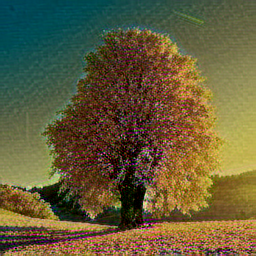

In [9]:
test()

6. Loss Analysis

In [ ]:
def plot_loss(train_history, val_history):
    x = range(1, num_epoch + 1)
    plt.plot(x, train_history, color='red', label='train loss')
    plt.plot(x, val_history, color='blue', label='val loss')
    plt.legend(loc='upper right')
    plt.savefig(f'./outputs/loss_graph_{season}.png')
    plt.show()
    return

In [ ]:
plot_loss(train_history, val_history)